In [991]:
import qiskit as qk
import random
from math import pi
import matplotlib.pyplot as plt
from qiskit import(QuantumCircuit,execute,Aer,IBMQ)
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit.quantum_info import Statevector
from qiskit.providers.aer.noise import NoiseModel

In [992]:
#===================
# Create QML model
#===================
import pennylane as qml
from pennylane import numpy as np

#==================================
# Fetch gradient descent optimizer
#==================================
from pennylane.optimize import GradientDescentOptimizer

In [993]:
#===========================================
# Build noise model from backend properties
#===========================================
IBMQ.save_account('0fbdb382eb11ab0fe752ceccce6e05056adafba8b5b0036998ee49a6ff117d799049d633f04529d2c8692710bfd02974e2fa9c3981b9357ccb166452de5b0211')
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

configrc.store_credentials:WARNING:2020-09-26 03:20:51,266: Credentials already present. Set overwrite=True to overwrite.
c:\users\prishitaray\appdata\programs\python\python37\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-09-26 03:20:52,556: Credentials are already in use. The existing account in the session will be replaced.


In [994]:
#===============================
# Get coupling map from backend
#===============================
coupling_map = backend.configuration().coupling_map

In [995]:
#==================================
# Get basis gates from noise model
#==================================
basis_gates = noise_model.basis_gates

In [996]:
#================
# Creating qubits
#================
q=qk.QuantumRegister(2)

In [997]:
#========================
#Creating Classical Bits
#========================

c=qk.ClassicalRegister(2)

In [998]:
#Target Probabilities

dev = qml.device("default.qubit",wires=2)

In [999]:
target_state = np.tensor([0, 0.5, 0.5, 0])

In [1000]:
#Training Vigo Noise Model with Gradient Descent Optimizer
#params=random.vonmisesvariate(mu=0, kappa=4)

steps = 1500
params = np.random.rand(1)
opt = GradientDescentOptimizer(0.1)
density = np.outer(target_state, target_state)

@qml.qnode(dev)
def circuit(var):
    density = np.outer(target_state, target_state)
    qml.RY(var[0], wires=0)
    qml.CNOT(wires=[0,1])
    qml.RX(pi, wires=1)
    return qml.expval(qml.Hermitian(density, wires=[0,1]))

def cost(var):
    return 0.5-circuit(var)

costs=[]

for i in range(steps):
    params = opt.step(cost, params)

    if (i + 1) % 100 == 0:
        print("Iteration Number {:5d} Cost: {: .20f}".format(i + 1, cost(params)))
    costs.append(cost(params))

print("Optimized parameters (theta for Ry): {}".format(params))

Iteration Number   100 Cost:  0.00265350581232498550
Iteration Number   200 Cost:  0.00001686935969513748
Iteration Number   300 Cost:  0.00000010666861927078
Iteration Number   400 Cost:  0.00000000067446581653
Iteration Number   500 Cost:  0.00000000000426458868
Iteration Number   600 Cost:  0.00000000000002697842
Iteration Number   700 Cost:  0.00000000000000022204
Iteration Number   800 Cost:  0.00000000000000011102
Iteration Number   900 Cost:  0.00000000000000000000
Iteration Number  1000 Cost:  0.00000000000000000000
Iteration Number  1100 Cost:  0.00000000000000000000
Iteration Number  1200 Cost:  0.00000000000000000000
Iteration Number  1300 Cost:  0.00000000000000000000
Iteration Number  1400 Cost:  0.00000000000000011102
Iteration Number  1500 Cost:  0.00000000000000011102
Optimized parameters (theta for Ry): [1.57079633]


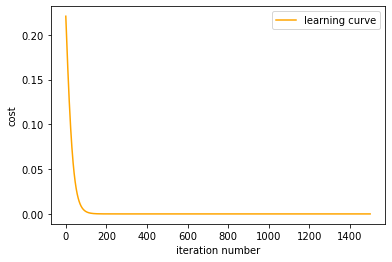

In [1001]:
colours = ["orange"]
plt.plot(range(steps), costs, colours[0], label="learning curve", linewidth=1.5)
plt.xlabel('iteration number')
plt.ylabel('cost')
plt.legend()
plt.show()

In [1002]:
#==================================================
# Rotation Operation Ry along y-axis on first qubit 
#==================================================
circuit=qk.QuantumCircuit(q)
circuit.ry(params[0],q[0])

In [1003]:
#============================================================================================
#CNOT Gate on the first to the second qubit (Negates second state only if first state is 1)
#============================================================================================
circuit.cx(0,1)

In [1004]:
#===================================================
#Rotation Operation Rx along x-axis on second qubit 
#===================================================
circuit.rx(pi,q[1])

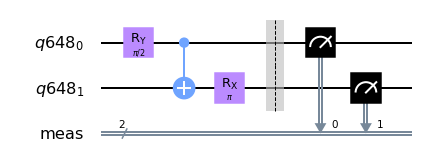

In [1005]:
#===============
#Display circuit
#===============
circuit.measure_all()
circuit.draw('mpl')

In [1006]:
simulator = Aer.get_backend('qasm_simulator')
sv_simulator = Aer.get_backend('statevector_simulator')

In [1007]:
#Checking for 1 measurements
# Execute the circuit on the qasm simulator
job = execute(circuit, simulator, shots=1,noise_model=noise_model)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("\nTotal count for 01 and 10 are:",counts)


Total count for 01 and 10 are: {'01': 1}


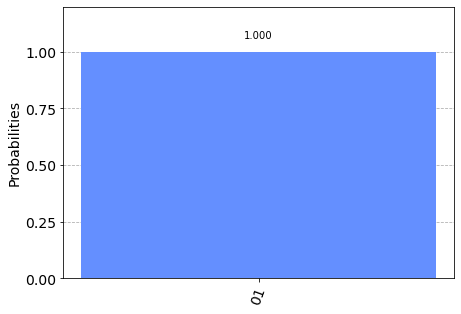

In [1008]:
#Histogram of probabilities for 01 and 10 in one measurement
plot_histogram(counts)


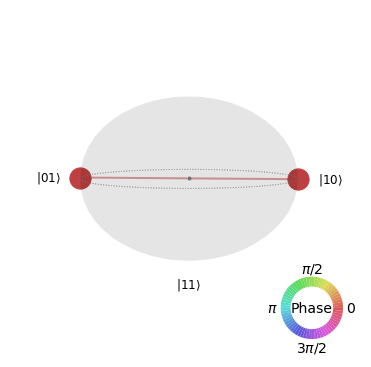

In [1009]:
plot_state_qsphere(
    Statevector.from_label('00').evolve(circuit.remove_final_measurements(inplace=False)),
    figsize=(6.5, 6.5)
)

In [1010]:
#Checking for 10 measurements
# Execute the circuit on the qasm simulator
job = execute(circuit, simulator, shots=10,noise_model=noise_model)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("\nTotal count for 01 and 10 are:",counts)


Total count for 01 and 10 are: {'01': 5, '10': 5}


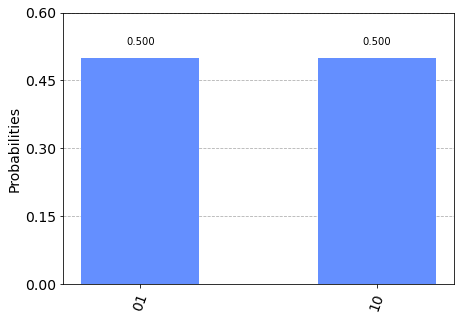

In [1011]:
#Histogram of probabilities for 01 and 10 in ten measurements
plot_histogram(counts)

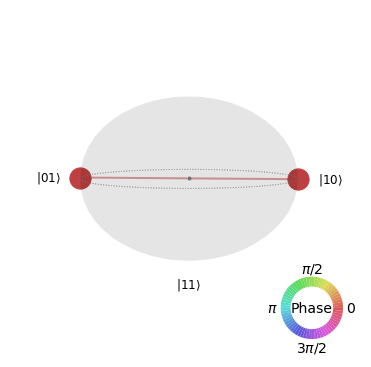

In [1012]:
plot_state_qsphere(
    Statevector.from_label('00').evolve(circuit.remove_final_measurements(inplace=False)),
    figsize=(6.5, 6.5)
)

In [1013]:
#Checking for 100 measurements
# Execute the circuit on the qasm simulator
job = execute(circuit, simulator, shots=100,noise_model=noise_model)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("\nTotal count for 01 and 10 are:",counts)


Total count for 01 and 10 are: {'00': 4, '01': 48, '10': 48}


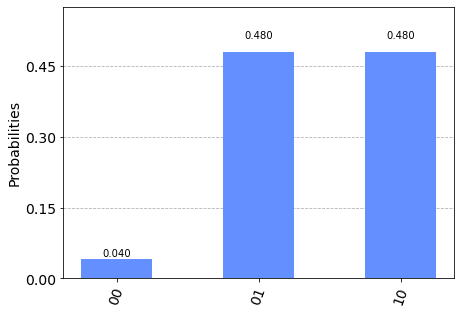

In [1014]:
#Histogram of probabilities for 01 and 10 in hundred measurements
plot_histogram(counts)

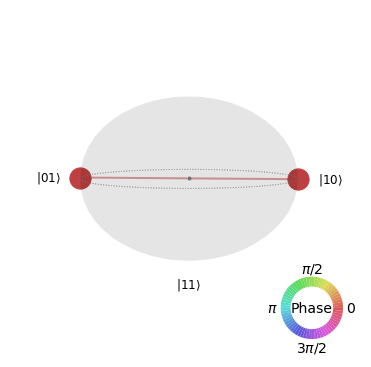

In [1015]:
plot_state_qsphere(
    Statevector.from_label('00').evolve(circuit.remove_final_measurements(inplace=False)),
    figsize=(6.5, 6.5)
)

In [1016]:
#Checking for 1000 measurements
# Execute the circuit on the qasm simulator
job = execute(circuit, simulator, shots=1000, noise_model=noise_model)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("\nTotal count for 01 and 10 are:",counts)


Total count for 01 and 10 are: {'00': 33, '01': 483, '10': 472, '11': 12}


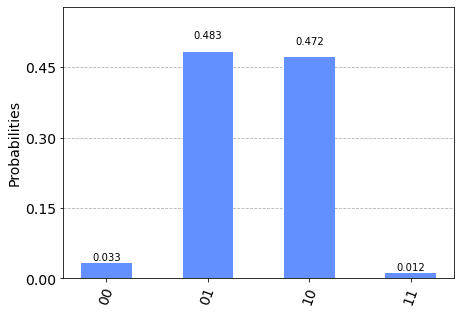

In [1017]:
#Histogram of probabilities for 01 and 10 in thousand measurements
plot_histogram(counts)

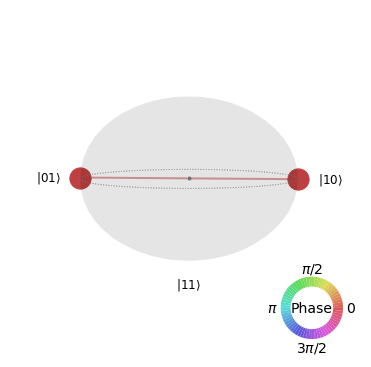

In [1018]:
plot_state_qsphere(
    Statevector.from_label('00').evolve(circuit.remove_final_measurements(inplace=False)),
    figsize=(6.5, 6.5)
)

In [ ]:
#Bonus Question 